导入包

In [129]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import torch 
from torch import nn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms,models,datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

预处理操作

In [130]:
data_dir='./data'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/valid'

In [131]:
data_transfroms = { 
    'train':transforms.Compose([
        transforms.RandomRotation(45),##随机转45°
        #transforms.CenterCrop(),##中心剪裁
        ##transforms.RandomHorizontalFlip(p=0.5),##随机水平镜像
        ##transforms.RandomVerticalFlip(p=0.5),##随机垂直镜像
        ##transforms.ColorJitter(brightness=1.5,contrast=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    'valid':transforms.Compose([
        #transforms.Resize(256),##调整大小
        #transforms.CenterCrop(80),##中心剪裁
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])

}

In [132]:
batch_size=16
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transfroms[x]) for x in ['train','valid']}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True )  for x in ['train','valid']}     
dataset_sizes={x: len(image_datasets[x])  for x in ['train','valid']}      
class_names=image_datasets['train'].classes
class_names


['0', '1', '2', '3', '4', '5']

In [133]:
with open('classes.json','r') as f:
    flower_names=json.load(f)
flower_names

{'0': 'NO.0', '1': 'NO.1', '2': 'NO.2', '3': 'NO.3', '4': 'NO.4', '5': 'NO.5'}

In [134]:
##以上函数对数据集进行了增强，中心化等预处理操作，下面是还原函数：
def im_convert(tensor):
    image =tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    for i in range(80):
        for j in range(80):
            image[:,i,j]=(image[:,i,j] *np.array([0.5,0.5,0.5])+np.array([0.5,0.5,0.5]))
    image =image.clip(0,1)
    image=image.transpose((1,2,0))
    return image

展示一下数据集

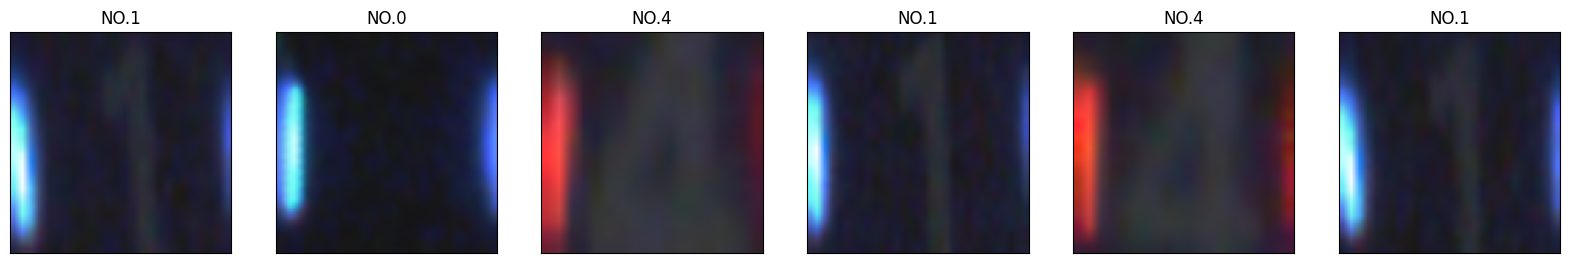

In [135]:
fig =plt.figure(figsize=(20,12))
colums=6
rows=1
dataiter =iter(dataloaders['valid'])
input ,classes =next(dataiter)

for idx in range(colums*rows):
    ax = fig.add_subplot(rows,colums,idx+1,xticks=[],yticks=[])
    ax.set_title(flower_names[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(input[idx]))

plt.show()

模型搭建

In [136]:
model_name="resnet"
feature_extract = True

In [137]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU!')
else:
    print('CUDA is available. Training on GPU!')
device=torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is available. Training on GPU!


In [138]:
model_ft = None
feature_extract=False

In [139]:
def set_parameter_requires_grad(model,feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad=False

In [140]:
class LeNet(nn.Module):
    """
    定义模型, 这里使用LeNet
    """

    def __init__(self):
        super(LeNet, self).__init__()
        # 卷积层
        self.conv = nn.Sequential(
            # 输入通道数, 输出通道数, kernel_size
            nn.Conv2d(1, 6, 5),
            nn.Sigmoid(),
            # 最大池化
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 7)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output
    

In [141]:
def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name=="resnet":
        """Resnet18"""
        model_ft=models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_firs =model_ft.fc.in_features
        model_ft.fc=nn.Sequential(nn.Linear(num_firs,num_classes),nn.LogSoftmax(dim=1))
        input_size=80

    if model_name=="alexnet":
        """Alexnet"""

        model_ft=models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_firs=model_ft.classifier[6].in_features
        model_ft.classifier[6]=nn.Linear(num_firs,num_classes)
        input_size=80
        
    if model_name=="vgg":
        """vgg"""

        model_ft=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_firs=model_ft.classifier[6].in_features
        model_ft.classifier[6]=nn.Linear(num_firs,num_classes)
        input_size=80
    
    if model_name=="lenet":
        """lenet"""

        model_ft=LeNet()
        model_ft.fc[4]=nn.Linear(84,num_classes)
        model_ft.conv[0]=nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        input_size=80
    

    



    return model_ft ,input_size
    
        

In [142]:
model_ft,input_size=initialize_model(model_name,6,feature_extract)

#转到GPU上
model_ft=model_ft.to(device)

#模型保存
filename="ArmoClassificacion.pth"

#是否训练所有参数

params_to_update=model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update=[]
    for name,param in model_ft.named_parameters():
        if param.requires_grad ==True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad ==True:
            print("\t",name)





Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

训练

In [143]:
#优化器设置
optimizer_ft=optim.Adam(params_to_update,lr=1e-2)#初始学习率0.01
scheduler=optim.lr_scheduler.StepLR(optimizer=optimizer_ft,step_size=5,gamma=0.1)#每五个epoch学习率变为原来的0.1
criterion=nn.NLLLoss()

In [144]:
#训练函数
def train_model(model,dataloaders,criterion,optimizer,num_epochs=25,is_inception=False,filename=filename):
    since=time.time()
    best_acc=0
    
    model.to(device)

    val_acc_history=[]
    train_acc_history=[]
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print("Epoch{}/{}".format(epoch+1,num_epochs))
        print('-'*10)

    #训练与验证
        for phase in ['train','valid']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            running_loss =0.0
            running_corrects=0
        #读取数据
            for inputs,lables in dataloaders[phase]:
                inputs=inputs.to(device)
                lables=lables.to(device)
            #梯度清零
                optimizer.zero_grad()
            #训练时更新梯度
                with torch.set_grad_enabled(phase=='train'):
                    if is_inception and phase=='train':
                        pass
                    else:
                        outputs=model(inputs)
                        loss=criterion(outputs,lables)

                    _,preds=torch.max(outputs,1)    

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==lables.data)  
        #计算损失
            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_corrects.double()/len(dataloaders[phase].dataset)
        #打印结果
            time_elapsed=time.time()-since
            print('Time elapsed{:.1f}m {:.1f}s'.format(time_elapsed//60,time_elapsed%60))  
            print('{}Loss:{:.4f} ACC:{:.4f}'.format(phase,epoch_loss,epoch_acc))   


        #保存最优模型  
            if phase =='valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                state={
                    'state_dict':model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer':optimizer.state_dict(),
                }
                torch.save(state,filename)
            if phase=='valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                ##scheduler.step(epoch_loss)
            if phase=='train':
                train_acc_history.append(epoch_loss)
                train_losses.append(epoch_loss)
        print('Optimizer learning ratr: {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best Acc:{:.4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model,val_acc_history,train_acc_history,valid_losses,train_losses,LRs

In [145]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs=train_model(model_ft,dataloaders,criterion,optimizer_ft,num_epochs=1)

Epoch1/1
----------
Time elapsed0.0m 13.7s
trainLoss:0.4831 ACC:0.8529
Time elapsed0.0m 14.2s
validLoss:0.0013 ACC:1.0000
Optimizer learning ratr: 0.0100000

Training complete in 0m 20s
Best Acc:1.0000


调用模型

In [146]:
model_ft,input_size=initialize_model(model_name,6,feature_extract)

model_ft.to(device)

filename='ArmoClassificacion.pth'

checkpoint=torch.load(filename)
best_acc=checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [147]:
def process_image(image_path):
    img=Image.open(image_path)

    img=img.resize((80,80))

    img=np.array(img)/255

    mean=np.array([0.5,0.5,0.5])

    std=np.array([0.5,0.5,0.5])

    img=(img-mean)/std

    img=img.transpose((2,0,1))

    return img
    


In [148]:
def imshow(image,ax=None,title=None):
    if ax is None:
        fig,ax=plt.subplots()

    image =np.array(image).transpose((1,2,0))    

    mean=np.array([0.5,0.5,0.5])

    std=np.array([0.5,0.5,0.5])

    image=image*std+mean

    image=np.clip(image,0,1)

    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')
    
    


[3 4 2 1 4 1 5 3 4 0 5 2 3 5 5 0]


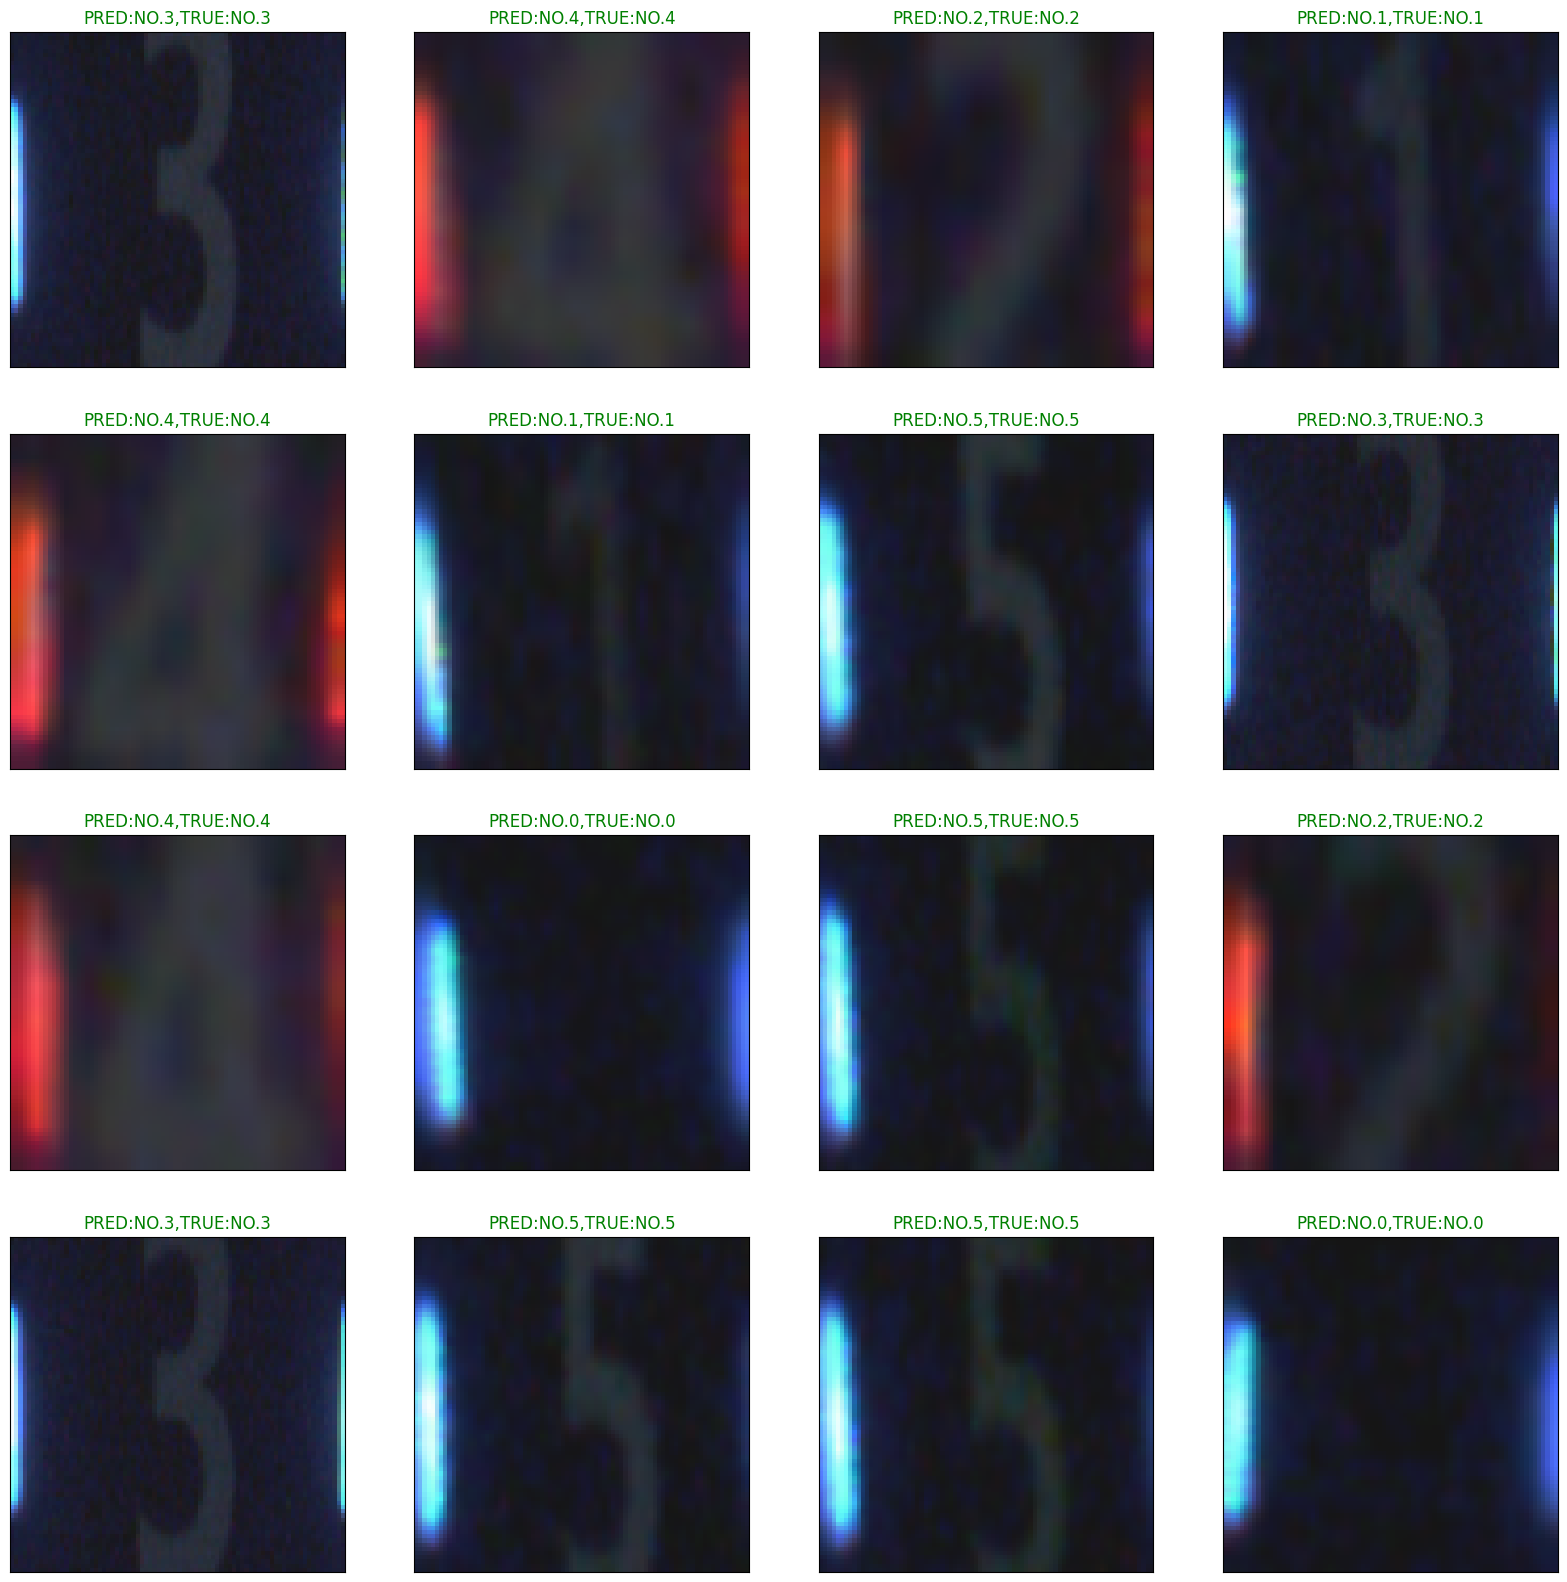

In [149]:
dataiter=iter(dataloaders['valid'])

images,labels=next(dataiter)

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

_,preds_tensor=torch.max(output,1)

preds=np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

preds=preds

print(preds)

fig =plt.figure(figsize=(20,20))
colums=4
rows=4

for idx in range(colums*rows):
    ax=fig.add_subplot(rows,colums,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("PRED:{},TRUE:{}".format(flower_names[str(preds[idx])],flower_names[str(labels[idx].item())]),
                 color=("green" if flower_names[str(preds[idx])]==flower_names[str(labels[idx].item())] else "red"))
plt.show()
    

网上随便搞一张图片测试

Prediction:3,True:3


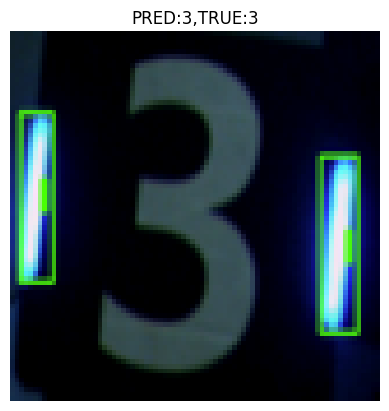

In [152]:
filename="3.png"
image1=process_image(filename)


output = model_ft(torch.unsqueeze(torch.FloatTensor(image1),0).to(device))
_,preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.cpu().numpy())
flower_names[str(preds)]

print("Prediction:"+str(preds)+",True:"+filename[0])
imshow(image1,title="PRED:{},TRUE:{}".format(preds,filename[0]))



    

In [151]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  